# VAE Training

## Import libraries

In [1]:
#Basic
import os
import numpy as np

#path
import sys
sys.path.append("../")

#Custom
import config
from src.models.train_model import sampling,encoder_model,decoder_model,vae_model,vae_loss
from src.models.callbacks import tensorboard,checkpoint,reduce_lr,LRTensorBoard
from src.visualization.visualize import plot_learning_curve
from config import intermediate_dim,latent_dim,batch_size,epochs

Using TensorFlow backend.


In [2]:
# Deep Learning
import keras
print(f"Keras version {keras.__version__}")

import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")


from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import RMSprop
from keras.metrics import binary_crossentropy


Keras version 2.3.1
Tensorflow version 1.14.0


In [3]:
latent_dim = 8

# Check data

Get (n_samples,width,height) into (n_samples,flatten_dimension)

In [4]:
os.listdir(config.DATA_PREPROCESSED_DIR)

['y_test.npy',
 'X_train.npy',
 '.gitignore',
 'X_valid.npy',
 'X_test.npy',
 'y_valid.npy',
 'y_train.npy']

In [5]:
X_train = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"X_train.npy"))
X_test = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"X_test.npy"))
X_valid = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"X_valid.npy"))

y_train = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"y_train.npy"))
y_test = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"y_test.npy"))
y_valid = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"y_valid.npy"))

input_shape = X_train[0].shape
original_dim = X_train[0].shape


In [6]:
print("Shapes info : \n")
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"X_valid shape : {X_valid.shape}")

print(f"y_train shape : {y_train.shape}")
print(f"y_test shape : {y_test.shape}")
print(f"input shape : {input_shape}")
print(f"output shape : {original_dim}")

Shapes info : 

X_train shape : (900, 900)
X_test shape : (180, 900)
X_valid shape : (120, 900)
y_train shape : (900, 900)
y_test shape : (180, 900)
input shape : (900,)
output shape : (900,)


In [7]:
print("Settings_info\n")
print(f"Intermediate_dim :  {intermediate_dim}")
print(f"Latent_dim : {latent_dim}")
print(f"Epochs : {epochs}")
print(f"Batch_size : {batch_size}")

Settings_info

Intermediate_dim :  512
Latent_dim : 8
Epochs : 1000
Batch_size : 128


# Initialize encoder 

In [8]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 900)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          461312      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

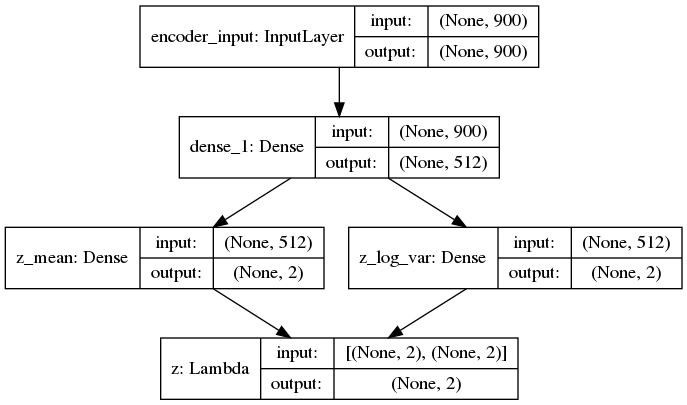

In [9]:
plot_model(encoder,show_shapes=True)

# Initialize decoder

## Decoder model

1. Tworzymy warstwe latent_input na wejscie podajac latend_dim
2. Następnie dodajemy warstwę pośrednią z tylu neuronów ilu chcieliśmy
3. Tworzymy warstwę wyjściową
4. zwracamy dekoder

In [10]:
original_dim = X_train[0].shape
decoder = decoder_model(original_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 900)               461700    
Total params: 463,236
Trainable params: 463,236
Non-trainable params: 0
_________________________________________________________________


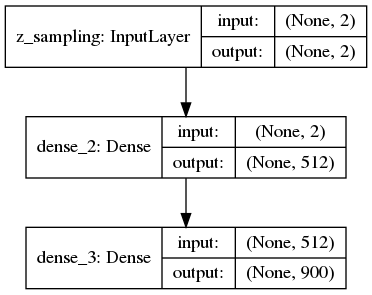

In [11]:
plot_model(decoder,show_shapes=True)

# Instantiate VAE model

In [12]:
outputs = decoder(encoder(inputs)[2])#biore outputy z dekodera
vae = Model(inputs, outputs, name='vae_mlp') # tworzę VAE

In [13]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 900)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 463364    
_________________________________________________________________
decoder (Model)              (None, 900)               463236    
Total params: 926,600
Trainable params: 926,600
Non-trainable params: 0
_________________________________________________________________


# Compile model

In [14]:
def vae_loss(y_true, y_pred):
    xent_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [15]:
# Compile model
optimizer = RMSprop(lr=0.0001)
loss = vae_loss
#vae.compile(optimizer=optimizer, loss="binary_crossentropy")
vae.compile(optimizer=optimizer, loss="binary_crossentropy")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training

In [16]:
epochs = 2000


In [17]:
X = X_train[0].reshape(1,900)
Y = y_train[0].reshape(1,900)
history = vae.fit(x=X, y=Y, epochs=epochs,batch_size=batch_size,
            callbacks=[checkpoint, reduce_lr])


Epoch 1/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.6930
Epoch 2/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6901
Epoch 3/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.6841
Epoch 4/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.6683
Epoch 5/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6572
Epoch 6/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6567
Epoch 7/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6660
Epoch 8/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6419
Epoch 9/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.6153
Epoch 10/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.5994
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.6272
Epoch 12/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.5739
Epoch 13/2000
1/1 [========================

/home/michal/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 23/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.5006
Epoch 24/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.4842
Epoch 25/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.4920
Epoch 26/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.4661
Epoch 27/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.4156
Epoch 28/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.4153
Epoch 29/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.4147
Epoch 30/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.3928
Epoch 31/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.3858
Epoch 32/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.4245
Epoch 33/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.3468
Epoch 34/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.3874
Epoch 35/2000
1/1 [=================

Epoch 125/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0915
Epoch 126/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0913
Epoch 127/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0916
Epoch 128/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0913
Epoch 129/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0909
Epoch 130/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0910
Epoch 131/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0909
Epoch 132/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0906
Epoch 133/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0909
Epoch 134/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0910
Epoch 135/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.0908
Epoch 136/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0903
Epoch 137/2000
1/1 [======

Epoch 226/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0888
Epoch 227/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0888
Epoch 228/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 229/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 230/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 231/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 232/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0887
Epoch 233/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0888
Epoch 234/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0888
Epoch 235/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 236/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0888
Epoch 237/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0888
Epoch 238/2000
1/1 [=======

1/1 [==============================] - 0s 7ms/step - loss: 0.0888
Epoch 328/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 329/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 330/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 331/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 332/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 333/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 334/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 335/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 336/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 337/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 338/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 339/2000
1/1 [=======================

Epoch 429/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 430/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 431/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 432/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 433/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 434/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0888
Epoch 435/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0888
Epoch 436/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 437/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 438/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 439/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 440/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 441/2000
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 0.0887
Epoch 531/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 532/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 533/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 534/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 535/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 536/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 537/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 538/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 539/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 540/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 541/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 542/2000
1/1 [====================

1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 632/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 633/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 634/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 635/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 636/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 637/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 638/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 639/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 640/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 641/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 642/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 643/2000
1/1 [=======================

Epoch 732/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 733/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 734/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 735/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 736/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 737/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 738/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 739/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 740/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 741/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 742/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 743/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0887
Epoch 744/2000
1/1 [=====

Epoch 833/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 834/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 835/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 836/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 837/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 838/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 839/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 840/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 841/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 842/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 843/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 844/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 845/2000
1/1 [======

Epoch 934/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 935/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 936/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 937/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 938/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 939/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 940/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 941/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 942/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 943/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 944/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 945/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 946/2000
1/1 [========

Epoch 1035/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1036/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1037/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1038/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1039/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1040/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1041/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1042/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1043/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1044/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1045/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1046/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1047/200

Epoch 1135/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1136/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1137/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1138/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1139/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0887
Epoch 1141/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1142/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1143/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1144/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1145/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1146/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1147/

Epoch 1235/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1236/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1237/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1238/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1239/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1240/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1241/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1242/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1243/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1244/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1245/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1246/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1247/2000

Epoch 1335/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1336/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1337/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1338/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1339/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1340/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1341/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1342/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1343/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1344/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1345/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1346/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1347/200

Epoch 1435/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1436/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1437/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1438/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1439/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1440/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1441/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0887
Epoch 1442/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1443/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0887
Epoch 1444/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1445/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1446/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1447/20

Epoch 1535/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1536/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1537/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1538/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1539/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1540/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1541/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1542/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1543/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1544/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1545/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1546/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1547/200

Epoch 1635/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1636/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1637/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1638/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1639/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1640/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1641/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1642/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1643/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1644/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1645/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1646/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1647/200

Epoch 1735/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1736/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1737/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1738/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1739/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1740/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1741/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1742/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1743/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1744/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1745/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1746/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1747/2000

Epoch 1835/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1836/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1837/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1838/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1839/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1840/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1841/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1842/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1843/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1844/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1845/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 1846/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1847/2

Epoch 1935/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1936/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1937/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0887
Epoch 1938/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1939/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1940/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch 1941/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0887
Epoch 1942/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1943/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 1944/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1945/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 1946/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 1947/200

In [ ]:
jeb

In [18]:
history = vae.fit(x=X_train, y=y_train, epochs=epochs,
                  validation_data=(X_valid,y_valid), batch_size=batch_size,
            callbacks=[checkpoint, reduce_lr])

Train on 900 samples, validate on 120 samples
Epoch 1/2000
900/900 [==============================] - 0s 155us/step - loss: 0.7238 - val_loss: 0.5751

Epoch 00001: val_loss improved from inf to 0.57508, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 2/2000
900/900 [==============================] - 0s 116us/step - loss: 0.5112 - val_loss: 0.4337

Epoch 00002: val_loss improved from 0.57508 to 0.43369, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 3/2000
900/900 [==============================] - 0s 106us/step - loss: 0.3903 - val_loss: 0.3422

Epoch 00003: val_loss improved from 0.43369 to 0.34224, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 4/2000
900/900 [==============================] - 0s 102us/step - loss: 0.3220 - val_loss: 0.3102

Epoch 00004: val_loss improved from 0.34224 to 0.31021, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 5/2000
9

900/900 [==============================] - 0s 94us/step - loss: 0.2602 - val_loss: 0.2619

Epoch 00043: val_loss did not improve from 0.26126
Epoch 44/2000
900/900 [==============================] - 0s 90us/step - loss: 0.2599 - val_loss: 0.2617

Epoch 00044: val_loss did not improve from 0.26126
Epoch 45/2000
900/900 [==============================] - 0s 99us/step - loss: 0.2599 - val_loss: 0.2630

Epoch 00045: val_loss did not improve from 0.26126
Epoch 46/2000
900/900 [==============================] - 0s 105us/step - loss: 0.2603 - val_loss: 0.2620

Epoch 00046: val_loss did not improve from 0.26126
Epoch 47/2000
900/900 [==============================] - 0s 98us/step - loss: 0.2598 - val_loss: 0.2614

Epoch 00047: val_loss did not improve from 0.26126
Epoch 48/2000
900/900 [==============================] - 0s 91us/step - loss: 0.2598 - val_loss: 0.2632

Epoch 00048: val_loss did not improve from 0.26126
Epoch 49/2000
900/900 [==============================] - 0s 122us/step - loss

Epoch 91/2000
900/900 [==============================] - 0s 102us/step - loss: 0.2596 - val_loss: 0.2612

Epoch 00091: val_loss did not improve from 0.26108
Epoch 92/2000
900/900 [==============================] - 0s 97us/step - loss: 0.2596 - val_loss: 0.2612

Epoch 00092: val_loss did not improve from 0.26108
Epoch 93/2000
900/900 [==============================] - 0s 95us/step - loss: 0.2596 - val_loss: 0.2612

Epoch 00093: val_loss did not improve from 0.26108
Epoch 94/2000
900/900 [==============================] - 0s 96us/step - loss: 0.2596 - val_loss: 0.2612

Epoch 00094: val_loss did not improve from 0.26108
Epoch 95/2000
900/900 [==============================] - 0s 106us/step - loss: 0.2595 - val_loss: 0.2612

Epoch 00095: val_loss did not improve from 0.26108
Epoch 96/2000
128/900 [===>..........................] - ETA: 0s - loss: 0.2636

KeyboardInterrupt: 

In [ ]:
fig = plot_learning_curve(history,figsize=(10,4))

In [ ]:
print(f"Loss : {round(history.history['loss'][-1],4)}")
print(f"Val Loss : {round(history.history['val_loss'][-1],4)}")
#print(f"Val Loss {history.history["val_loss"][-1]}")

In [ ]:
# metoda do wyciągania quality indicatora
# zapisywanie w notatniku
# DVC 